###**DEEP LEARNING ANN FOR 8500 SAMPLES PER CLASS.**

# Import Data for X and y

In [1]:
import pickle
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers, initializers
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.initializers import HeUniform

In [2]:
with open('/content/df_features_train8500.pickle', 'rb') as f:
    df_train = pickle.load(f)

In [3]:
df_train.head()

,harmonic,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,chroma_10,chroma_11,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,targets
bass_synthetic_072-103-050,1,-259.120392,16.254854,-48.653900,56.044502,-48.498081,49.107578,-28.063169,33.163216,-29.868616,...,0.016615,0.021126,18.358565,26.506755,23.400589,24.589065,33.968219,30.536804,70.548043,0
bass_electronic_005-041-075,1,-445.705505,123.459839,62.945370,31.896797,25.574553,24.210548,14.594964,0.539918,-4.144855,...,0.019849,0.042269,29.413068,22.887350,27.154730,28.345323,21.895214,15.876317,38.530831,0
bass_electronic_032-048-050,0,-441.677917,54.611637,19.976978,48.740196,18.194162,17.925045,13.445016,-5.536787,5.831507,...,0.132179,0.135995,34.581794,29.261612,24.449808,21.815215,19.180553,23.966423,53.539505,0
bass_synthetic_084-057-075,1,-267.839111,111.263550,-42.105766,1.328193,-11.390604,8.398848,-12.949695,-7.446430,-16.948307,...,0.103571,0.024353,21.855462,25.989365,31.744667,26.859090,26.837624,23.338994,50.647930,0
bass_synthetic_114-082-127,1,-264.461121,36.348366,-42.848892,43.289532,-22.449223,25.279791,5.725794,35.342300,23.236238,...,0.858397,0.068264,17.983583,16.328056,13.776016,33.808865,28.329224,27.039600,64.354064,0


In [4]:
df_train.shape

(85000, 162)

In [5]:
X_train = df_train.drop(labels=['targets'], axis=1)
y_train = df_train['targets']

X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.05,
                                                    random_state=42)


X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.05,
                                                  random_state=42)

In [6]:
# Normalize the data

normalizer = MinMaxScaler()
scaler = StandardScaler()


X_train_normalized = normalizer.fit_transform(X_train)
X_train_normalized_standardized = scaler.fit_transform(X_train_normalized)

X_test_normalized = normalizer.fit_transform(X_test)
X_test_normalized_standardized = scaler.fit_transform(X_test_normalized)

X_valid_normalized = normalizer.fit_transform(X_valid)
X_valid_normalized_standardized = scaler.fit_transform(X_valid_normalized)

In [7]:
# Encoding target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_valid_encoded = label_encoder.transform(y_valid)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the target variable
y_train_one_hot = to_categorical(y_train_encoded)
y_val_one_hot = to_categorical(y_valid_encoded)
y_test_one_hot = to_categorical(y_test_encoded)

In [8]:
# Define input shape
input_shape = X_train.shape[1:]
print(input_shape)

(161,)


In [9]:
# Define number of classes
num_classes = len(set(y_train))
print(num_classes)

10


# Define Confusion Matrix Function

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

In [11]:
class_names=np.array(['bass', 'brass', 'flute', 'guitar',
             'keyboard', 'mallet', 'organ', 'reed',
             'string', 'vocal'])

# ANN Simple Model

In [12]:
# Define the model architecture
simple_model = Sequential()
simple_model.add(Dense(64, input_shape=input_shape, activation='relu'))
simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dense(256, activation='relu'))
simple_model.add(Dense(128, activation='relu'))
simple_model.add(Dense(32, activation='relu'))
simple_model.add(Dense(num_classes, activation='softmax'))

In [13]:
# Print model summary
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                10368     
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 89066 (347.91 KB)
Trainable params: 89066 

In [14]:
# Compile the model
simple_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# Train the model
history_simple_model = simple_model.fit(X_train_normalized_standardized, y_train_one_hot,
                    epochs=150,
                    batch_size=32,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_valid_normalized_standardized, y_val_one_hot))

Epoch 1/150
2398/2398 [==============================] - 7s 2ms/step - loss: 1.2736 - accuracy: 0.5352 - val_loss: 1.0069 - val_accuracy: 0.6285
Epoch 2/150
2398/2398 [==============================] - 5s 2ms/step - loss: 0.8569 - accuracy: 0.6907 - val_loss: 0.8147 - val_accuracy: 0.7140
Epoch 3/150
2398/2398 [==============================] - 5s 2ms/step - loss: 0.6918 - accuracy: 0.7486 - val_loss: 0.7278 - val_accuracy: 0.7340
Epoch 4/150
2398/2398 [==============================] - 5s 2ms/step - loss: 0.5898 - accuracy: 0.7863 - val_loss: 0.6271 - val_accuracy: 0.7784
Epoch 5/150
2398/2398 [==============================] - 5s 2ms/step - loss: 0.5165 - accuracy: 0.8132 - val_loss: 0.5851 - val_accuracy: 0.7954
Epoch 6/150
2398/2398 [==============================] - 5s 2ms/step - loss: 0.4576 - accuracy: 0.8338 - val_loss: 0.5497 - val_accuracy: 0.8118
Epoch 7/150
2398/2398 [==============================] - 5s 2ms/step - loss: 0.4140 - accuracy: 0.8494 - val_loss: 0.5231 - val_ac

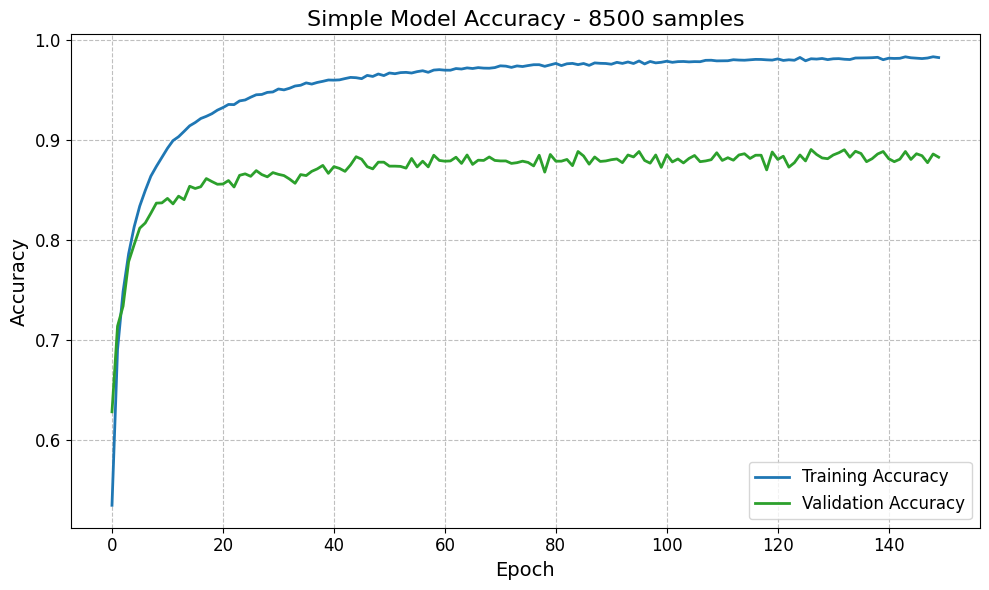

In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history_simple_model.history['accuracy'], label='Training Accuracy', color='tab:blue', linewidth=2)
plt.plot(history_simple_model.history['val_accuracy'], label='Validation Accuracy', color='tab:green', linewidth=2)
plt.title('Simple Model Accuracy - 8500 samples', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

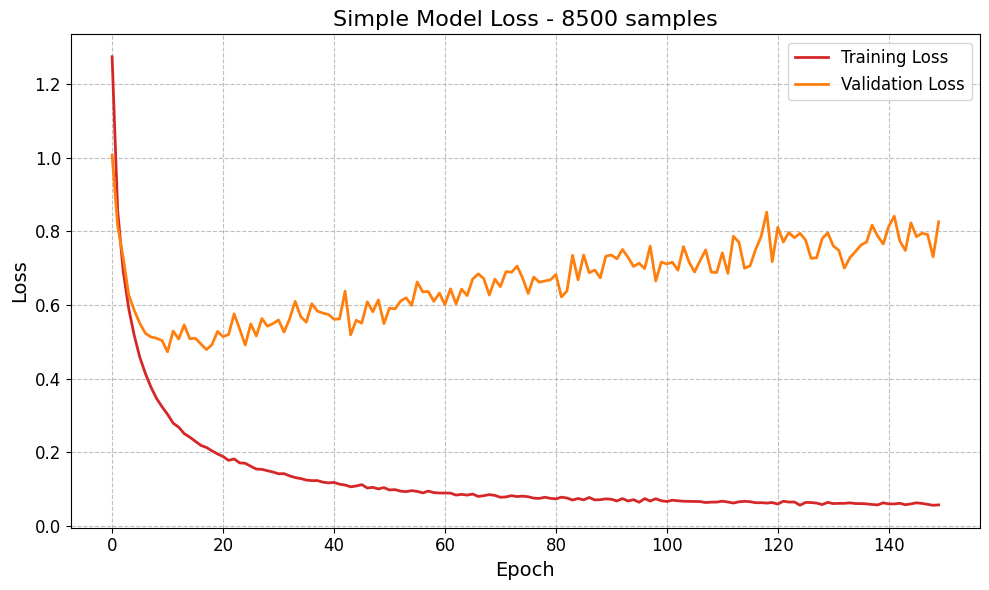

In [17]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_simple_model.history['loss'], label='Training Loss', color='tab:red', linewidth=2)
plt.plot(history_simple_model.history['val_loss'], label='Validation Loss', color='tab:orange', linewidth=2)
plt.title('Simple Model Loss - 8500 samples', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = simple_model.evaluate(X_test_normalized_standardized, y_test_one_hot)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

133/133 [==============================] - 0s 1ms/step - loss: 0.8360 - accuracy: 0.8840
Test Accuracy: 88.40%


In [19]:
# Get predictions
y_pred_probs = simple_model.predict(X_test_normalized_standardized)
y_pred = np.argmax(y_pred_probs, axis=1)

133/133 [==============================] - 0s 1ms/step


Normalized confusion matrix
[[0.77590361 0.00240964 0.01686747 0.03855422 0.05060241 0.04819277
  0.02650602 0.01927711 0.00722892 0.01445783]
 [0.         0.97122302 0.         0.         0.00239808 0.
  0.         0.02398082 0.00239808 0.        ]
 [0.02216749 0.00246305 0.94827586 0.00246305 0.         0.00492611
  0.00246305 0.01477833 0.00246305 0.        ]
 [0.06430155 0.00221729 0.00665188 0.76274945 0.05321508 0.06208426
  0.01773836 0.00443459 0.02660754 0.        ]
 [0.04697987 0.00671141 0.00223714 0.05369128 0.76510067 0.08277405
  0.02013423 0.01342282 0.00894855 0.        ]
 [0.03553299 0.         0.00507614 0.0177665  0.05076142 0.86294416
  0.00761421 0.00507614 0.01269036 0.00253807]
 [0.02534562 0.00230415 0.         0.00691244 0.00460829 0.01382488
  0.94470046 0.00230415 0.         0.        ]
 [0.01084599 0.00867679 0.06941432 0.         0.0021692  0.
  0.00433839 0.89587852 0.00650759 0.0021692 ]
 [0.00243309 0.         0.00243309 0.00243309 0.00243309 0.00243309


<Axes: title={'center': 'Simple ANN Model Normalized confusion matrix - 8500 samples'}, xlabel='Predicted label', ylabel='True label'>

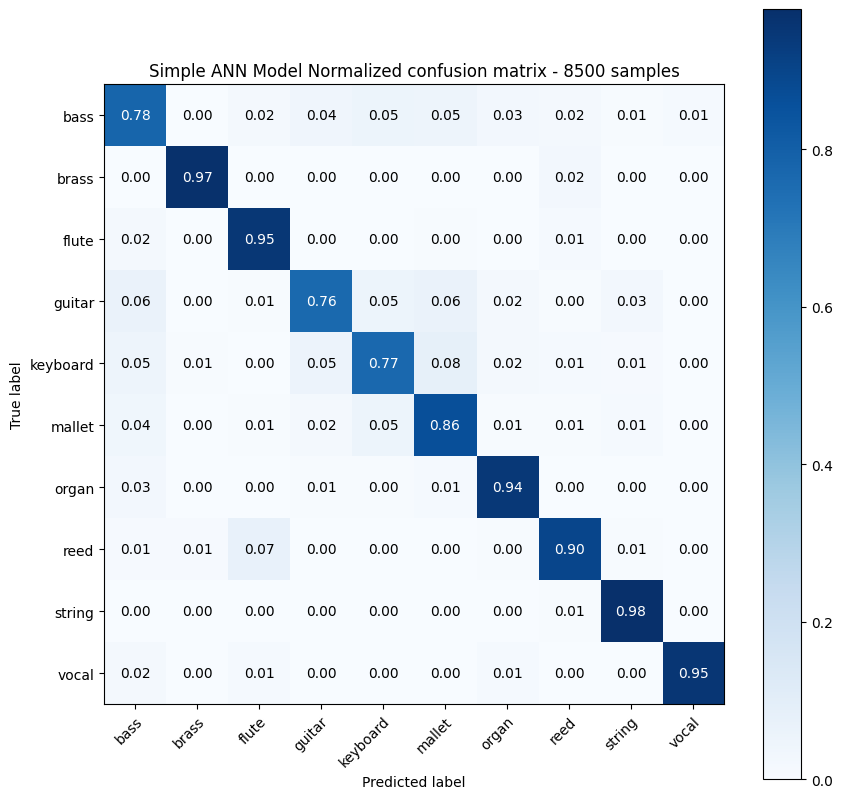

In [20]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Simple ANN Model Normalized confusion matrix - 8500 samples')

# ANN Dropout Model


In [21]:
# Define the model architecture
dropout_model = Sequential()
dropout_model.add(Dense(128, input_shape=input_shape, activation='elu'))
dropout_model.add(Dense(256, activation='relu'))
dropout_model.add(Dense(512, activation='relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(256, activation='relu'))
dropout_model.add(Dense(512, activation='relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(128, activation='relu'))
dropout_model.add(Dense(64, activation='relu'))
dropout_model.add(Dense(32, activation='elu'))
dropout_model.add(Dense(num_classes, activation='softmax'))

In [22]:
# Print model summary
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               20736     
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)              

In [23]:
# Compile the model
dropout_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
# Train the model
history_dropout_model = dropout_model.fit(X_train_normalized_standardized, y_train_one_hot,
                    epochs=600,
                    batch_size=64,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_valid_normalized_standardized, y_val_one_hot))

Epoch 1/600
1199/1199 [==============================] - 10s 7ms/step - loss: 1.4235 - accuracy: 0.4756 - val_loss: 1.0737 - val_accuracy: 0.6018
Epoch 2/600
1199/1199 [==============================] - 8s 7ms/step - loss: 1.0130 - accuracy: 0.6287 - val_loss: 0.8680 - val_accuracy: 0.6890
Epoch 3/600
1199/1199 [==============================] - 8s 7ms/step - loss: 0.8584 - accuracy: 0.6897 - val_loss: 0.7895 - val_accuracy: 0.7117
Epoch 4/600
1199/1199 [==============================] - 8s 7ms/step - loss: 0.7611 - accuracy: 0.7276 - val_loss: 0.7129 - val_accuracy: 0.7491
Epoch 5/600
1199/1199 [==============================] - 8s 7ms/step - loss: 0.6903 - accuracy: 0.7512 - val_loss: 0.6265 - val_accuracy: 0.7732
Epoch 6/600
1199/1199 [==============================] - 8s 7ms/step - loss: 0.6418 - accuracy: 0.7705 - val_loss: 0.5771 - val_accuracy: 0.7940
Epoch 7/600
1199/1199 [==============================] - 9s 7ms/step - loss: 0.5934 - accuracy: 0.7885 - val_loss: 0.5717 - val_a

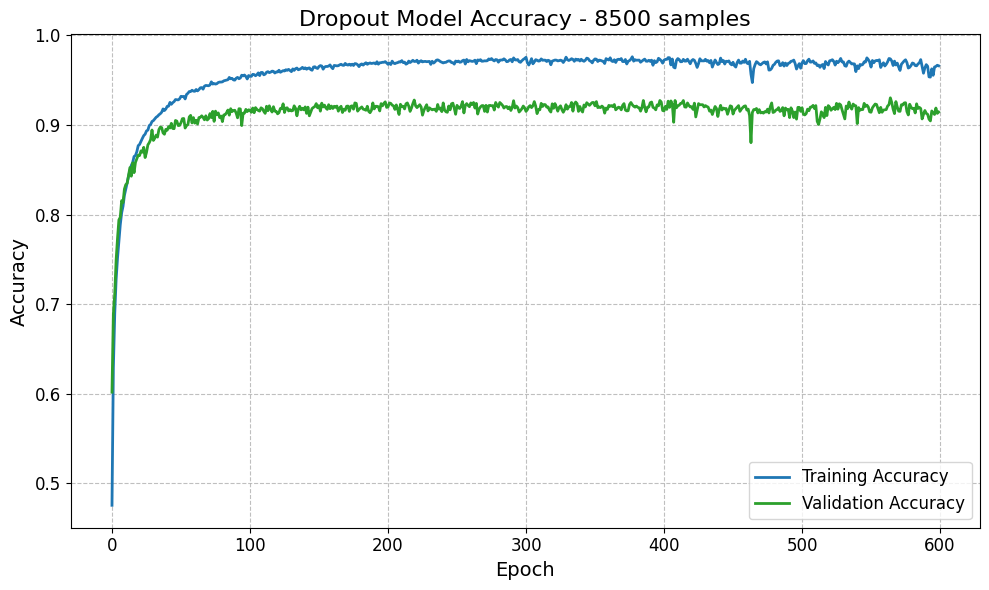

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history_dropout_model.history['accuracy'], label='Training Accuracy', color='tab:blue', linewidth=2)
plt.plot(history_dropout_model.history['val_accuracy'], label='Validation Accuracy', color='tab:green', linewidth=2)
plt.title('Dropout Model Accuracy - 8500 samples', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

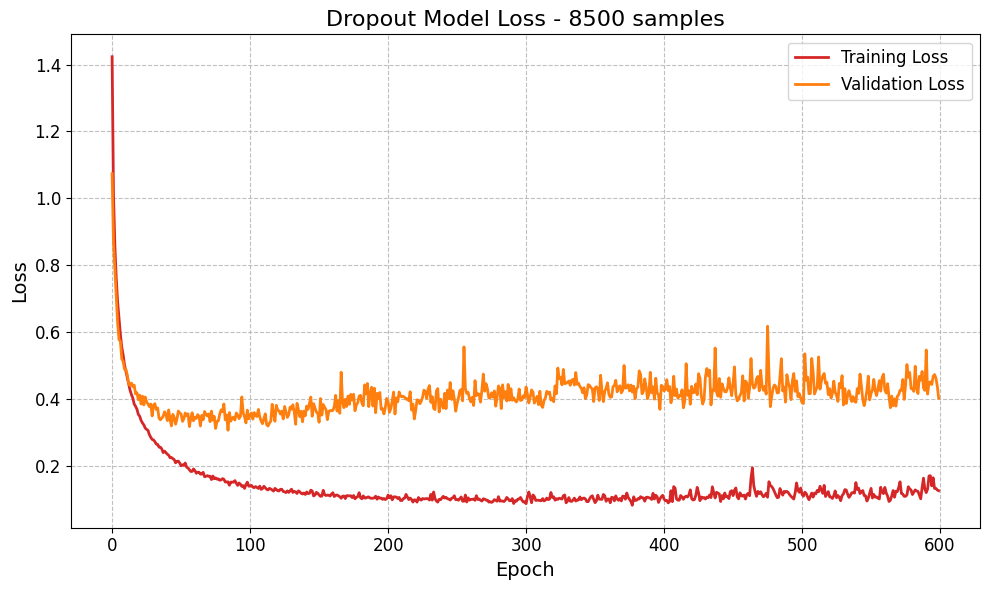

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_dropout_model.history['loss'], label='Training Loss', color='tab:red', linewidth=2)
plt.plot(history_dropout_model.history['val_loss'], label='Validation Loss', color='tab:orange', linewidth=2)
plt.title('Dropout Model Loss - 8500 samples', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = dropout_model.evaluate(X_test_normalized_standardized, y_test_one_hot)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

133/133 [==============================] - 0s 2ms/step - loss: 0.3825 - accuracy: 0.9078
Test Accuracy: 90.78%


In [28]:
# Get predictions
y_pred_probs = dropout_model.predict(X_test_normalized_standardized)
y_pred = np.argmax(y_pred_probs, axis=1)

133/133 [==============================] - 0s 2ms/step


Normalized confusion matrix
[[0.81927711 0.00963855 0.00963855 0.02891566 0.03614458 0.03614458
  0.00963855 0.02168675 0.00963855 0.01927711]
 [0.00239808 0.99520384 0.         0.         0.         0.
  0.         0.         0.00239808 0.        ]
 [0.02216749 0.00246305 0.94334975 0.         0.         0.
  0.         0.01970443 0.00985222 0.00246305]
 [0.07095344 0.00665188 0.00886918 0.78713969 0.06208426 0.01995565
  0.00886918 0.00665188 0.02882483 0.        ]
 [0.049217   0.00447427 0.00671141 0.01565996 0.83892617 0.05369128
  0.01118568 0.00671141 0.00894855 0.00447427]
 [0.03807107 0.         0.00761421 0.05837563 0.04314721 0.82994924
  0.00253807 0.00761421 0.00761421 0.00507614]
 [0.02304147 0.         0.         0.00230415 0.00691244 0.00230415
  0.96543779 0.         0.         0.        ]
 [0.01301518 0.01301518 0.02169197 0.         0.         0.
  0.         0.94577007 0.00433839 0.0021692 ]
 [0.00486618 0.         0.         0.00243309 0.         0.
  0.         0.0

<Axes: title={'center': 'Dropout ANN Model Normalized confusion matrix - 8500 samples'}, xlabel='Predicted label', ylabel='True label'>

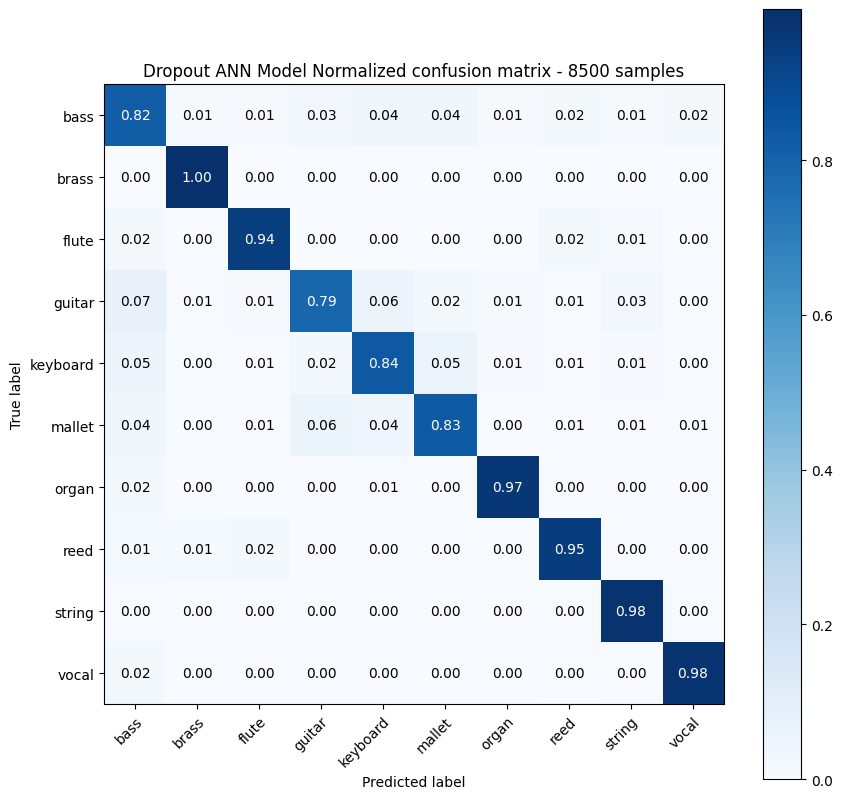

In [29]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Dropout ANN Model Normalized confusion matrix - 8500 samples')

# ANN Complex Model

In [39]:
complex_model = Sequential()
complex_model.add(Dense(256, input_shape=input_shape, activation='elu', kernel_initializer=GlorotUniform()))
complex_model.add(Dense(128, activation='relu'))
complex_model.add(Dense(256, activation='relu', kernel_initializer=HeUniform()))
complex_model.add(Dense(512, activation='leaky_relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
complex_model.add(layers.Dropout(0.2))
complex_model.add(Dense(256, activation='relu'))
complex_model.add(Dense(64, activation='relu'))
complex_model.add(Dense(1024, activation='tanh',kernel_regularizer=tf.keras.regularizers.l2(0.01)))
complex_model.add(Dense(512, activation='relu'))
complex_model.add(layers.Dropout(0.4))
complex_model.add(Dense(256, activation='relu', kernel_initializer=HeUniform()))
complex_model.add(Dense(128, activation='relu'))
complex_model.add(Dense(128, activation='leaky_relu'))
complex_model.add(layers.Dropout(0.2))
complex_model.add(Dense(64, activation='elu', kernel_initializer=GlorotUniform()))
complex_model.add(Dense(num_classes, activation='softmax'))

In [40]:
# Print model summary
complex_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 256)               41472     
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 256)               33024     
                                                                 
 dense_31 (Dense)            (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               131328    
                                                                 
 dense_33 (Dense)            (None, 64)               

In [43]:
# Compile the model
complex_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

In [44]:
# Train the model
history_complex_model = complex_model.fit(X_train_normalized_standardized, y_train_one_hot,
                    epochs=500,
                    batch_size=64,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_valid_normalized_standardized, y_val_one_hot))

Epoch 1/500
1199/1199 [==============================] - 15s 11ms/step - loss: 3.4423 - accuracy: 0.3305 - val_loss: 1.6431 - val_accuracy: 0.4522
Epoch 2/500
1199/1199 [==============================] - 13s 11ms/step - loss: 1.5324 - accuracy: 0.4996 - val_loss: 1.4743 - val_accuracy: 0.5285
Epoch 3/500
1199/1199 [==============================] - 13s 11ms/step - loss: 1.3938 - accuracy: 0.5583 - val_loss: 1.3455 - val_accuracy: 0.5770
Epoch 4/500
1199/1199 [==============================] - 13s 11ms/step - loss: 1.3110 - accuracy: 0.5946 - val_loss: 1.3019 - val_accuracy: 0.5936
Epoch 5/500
1199/1199 [==============================] - 13s 11ms/step - loss: 1.2514 - accuracy: 0.6211 - val_loss: 1.2711 - val_accuracy: 0.6122
Epoch 6/500
1199/1199 [==============================] - 13s 11ms/step - loss: 1.2037 - accuracy: 0.6435 - val_loss: 1.2100 - val_accuracy: 0.6248
Epoch 7/500
1199/1199 [==============================] - 13s 11ms/step - loss: 1.1665 - accuracy: 0.6584 - val_loss: 1

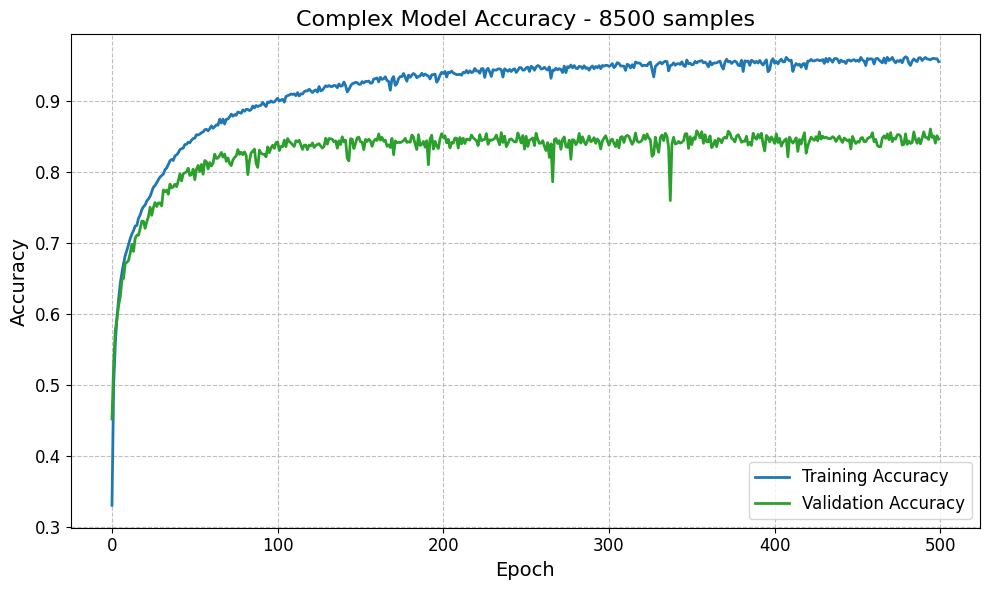

In [45]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history_complex_model.history['accuracy'], label='Training Accuracy', color='tab:blue', linewidth=2)
plt.plot(history_complex_model.history['val_accuracy'], label='Validation Accuracy', color='tab:green', linewidth=2)
plt.title('Complex Model Accuracy - 8500 samples', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

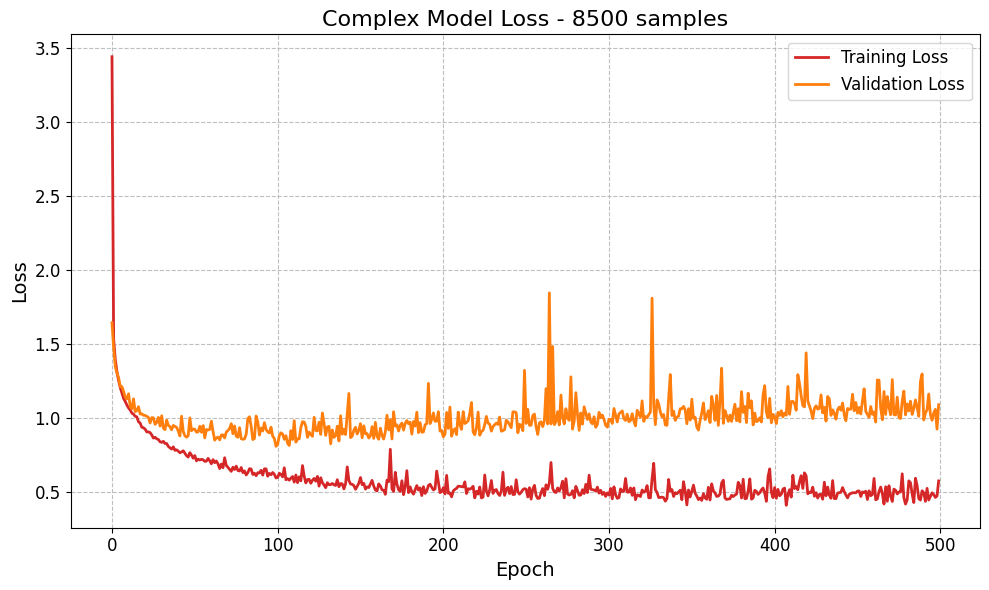

In [46]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_complex_model.history['loss'], label='Training Loss', color='tab:red', linewidth=2)
plt.plot(history_complex_model.history['val_loss'], label='Validation Loss', color='tab:orange', linewidth=2)
plt.title('Complex Model Loss - 8500 samples', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

In [47]:
# Evaluate the model on the test set
test_loss, test_accuracy = complex_model.evaluate(X_test_normalized_standardized, y_test_one_hot)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

133/133 [==============================] - 0s 3ms/step - loss: 1.0680 - accuracy: 0.8461
Test Accuracy: 84.61%


In [48]:
# Get predictions
y_pred_probs = complex_model.predict(X_test_normalized_standardized)
y_pred = np.argmax(y_pred_probs, axis=1)

133/133 [==============================] - 1s 3ms/step


Normalized confusion matrix
[[0.67951807 0.00240964 0.02168675 0.12771084 0.02891566 0.0313253
  0.0313253  0.05542169 0.00722892 0.01445783]
 [0.         0.98800959 0.         0.00239808 0.         0.
  0.         0.00239808 0.00479616 0.00239808]
 [0.01970443 0.00246305 0.93842365 0.01724138 0.         0.
  0.00246305 0.01970443 0.         0.        ]
 [0.0864745  0.00665188 0.00443459 0.76718404 0.05764967 0.0421286
  0.00886918 0.00886918 0.01330377 0.00443459]
 [0.06935123 0.00894855 0.00223714 0.13870246 0.68456376 0.05592841
  0.02684564 0.00447427 0.00671141 0.00223714]
 [0.04822335 0.00253807 0.00253807 0.12944162 0.07360406 0.71827411
  0.00507614 0.01015228 0.00253807 0.00761421]
 [0.03225806 0.         0.00230415 0.         0.01843318 0.00921659
  0.92626728 0.00460829 0.         0.00691244]
 [0.02819957 0.01952278 0.05856833 0.01735358 0.0021692  0.
  0.         0.86550976 0.0021692  0.00650759]
 [0.01216545 0.         0.00243309 0.01703163 0.         0.00243309
  0.      

<Axes: title={'center': 'Complex ANN Model Normalized confusion matrix - 8500 samples'}, xlabel='Predicted label', ylabel='True label'>

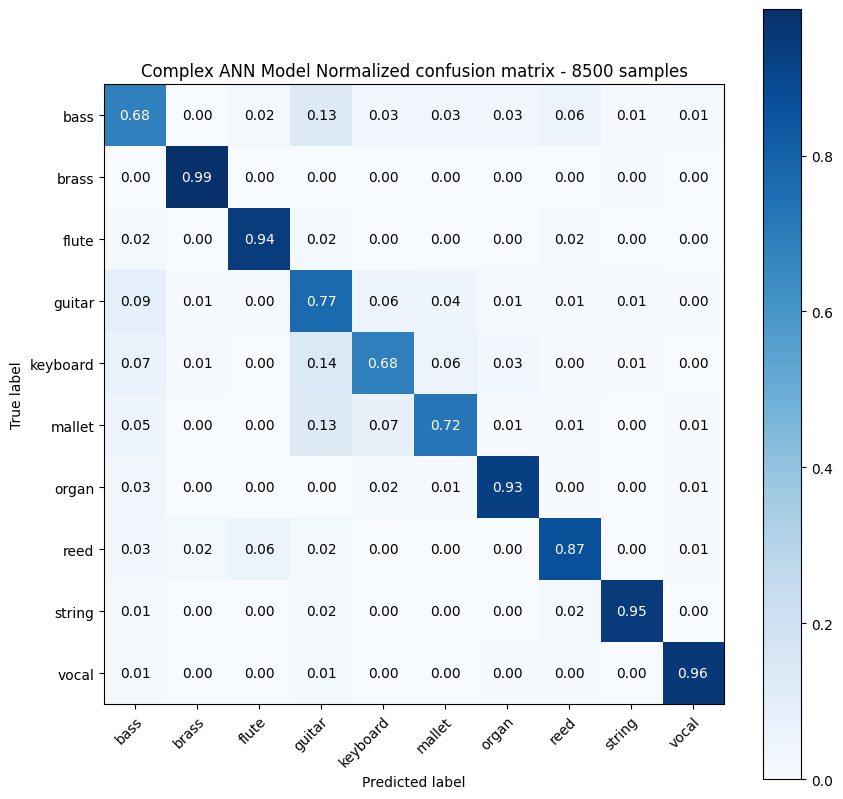

In [49]:
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Complex ANN Model Normalized confusion matrix - 8500 samples')